# Model for mixed-dimensional flow

This notebook aims to introduce the basic concepts involved in running a simulation in PorePy, by investigating fluid flow in a fractured porous media. The notebook will cover
* A brief overview of the governing equations.
* An illustation of how to specify a domain with a fracture network and how to generate a mesh that conforms to the fractures.
* An overview of the ingredients needed to specify a full simulaiton in PorePy.
* An example of how to make simple modifications to the default model for fluid flow, and directions for further extensions.


## Problem statement: A mathematical model for fluid flow in fractured domains
Our problem consists of the following ingreidents:
1. A domain with some fractures embedded.
2. Equations which impose conservation of mass.
3. Constitutive laws for the relation between the fluid pressure and flux.


We will go through all these components in turn. The presentation will use some mathematical terminology without being overly technicaly.
This emphasis on mathematics reflects the philosophy underlying PorePy: Problems are stated in terms of equations, and this mathematical structure is reflected in discretization and implementation.
Thus, while it is possible to follow this notebook, and more generally to use PorePy, without reflecting much on the mathematical problem formulation, harnessing the full potential of the software requires a certain fluency in mathematics.

It should also be mentioned that the aim is to cover the important concepts and we may sometimes prioritize ease of presentation over precision in the arguments. More precise arguments can be found in the papers that describe the various parts of PorePy.

### Fracture network geometry
Let $\Omega_0$ be a regular domain with boundary $\partial \Omega_F$. 
In $\Omega_0$, we introduce a set of fractures, which we can denote as $\Omega_i^F$, where $i$ is a counter of the fractures. Crucially, we will consider fractures to be objects of dimension one less than the host domain, so, for a 2d domain, a fracture is 1d. 
Moreover, we will assume that all fractures are straight lines (in 2d domains) and planar (in 3d domains). For 2d domains, this means we can describe a fracture by its start- and endpoint.


We will also need a description of the boundary of $\Omega_0$. This will in part consist of the external boundary, which can be divided in two non-overlapping parts on which we will impose Dirichlet ($\partial \Omega_0^d$) and Neumann ($\partial \Omega_0^n$) boundary conditions, respectively.
More interesting is the boundary of $\Omega_0$ towards the fractures $\Omega_i^F$, which we will represent by $\partial\Omega_i^F$, and occasionally write $\partial^{\pm}\Omega_i^F$ to denote the two sides of the fracture.

For simplicity, we have not included notation to describe intersection between two fractures. 

### Conservation equations
Assuming the fluid is incompressible, we have from basic continuum mechanics that conservation of mass for a domain $\Omega$ is described by the equation

$$ \nabla \cdot \mathbf{q} = f, \,\,in\,\, \Omega$$

Here, $\mathbf{q}$ is the fluid flux and $f$ represents source terms. 
In addition comes boundary conditions, on the form 
$$\mathbf{q}\cdot\mathbf{n} = q_N, \,\,on\,\, \partial\Omega^N, \qquad p=p_D \,\,on\,\, \partial\Omega^D$$
of Neumann and Dirichlet type, respectively, where we have introduced the fluid pressure $p$.

To make this general equation fit with a fractured media, we first introduce the flux $\lambda_i^{\pm}$ between $\Omega_0$ and a fracture $\Omega_i^F$. For $\Omega_0$ the interface to the fracture takes the form of a standard boundary, and $\lambda_i^{\pm}$ enters as an additional Neumann boundary condition, $\mathbf{q}\cdot\mathbf{n} = \lambda_i^{\pm},  \,\,on\,\, \partial_i^{pm}\Omega_0$ ($\mathbf{n}$ is here the outer normal vector), thus $\lambda_i$ is positive for flow from $\Omega_0$ to $\Omega_i^F$).
The fracture $\Omega_i^F$ has no proper boundary towards $\Omega_0$ (recall that $\partial_i^{pm}\Omega_0$ has the same dimension as $\Omega_i^F$). Flow from $\Omega_0$ to $\Omega_i^F$ instead manifests as a source term, and conservation of mass is expressed as 

$$ \nabla \cdot \mathbf{q}_i - (\lambda_i^+ + \lambda_i^-) = f, \,\,in\,\, \Omega_i^F.$$


### Constitutive laws
To close the model, we need constitutive laws for the fluxes $\mathbf{q}_0$, $\mathbf{q}_i \,\, (i>0)$ and $\lambda_i^{\pm}$.
In $\Omega_0$ we apply Darcy's law and write 
$$\mathbf{q}_0 = \mathbf{K}_0\nabla p_0$$
In $\Omega_i^F$ we will assign the permeability according to the so-called cubic law, and set

$$\mathbf{q}_i = \mathbf{K}_i , \qquad K_i=\frac{a^3}{12}, \qquad i=\{1, 2, ...\}$$

where $a$ is the fracture aperture. 

Finally, the flux $\lambda$ is related to the pressure on the two surrounding sides by

$$\lambda_i = \kappa(p_0 - p_i),  \qquad i=\{1, 2, ...\} $$

Here, the parameter $\kappa$ can be considered the permeability of the fracture in its normal direction.

This definition follows the convention in PorePy that an interface flux is positive if it goes from the higher- to the lower-dimensional domain.

### Extension to fracture intersections
The above framework can readily be extended to domains where fractures intersect to form domains of dimension $nd-2$ and, in 3d, intersections of intersection lines (e.g., points that have dimension $nd-3).
The intersections will form separate subdomains with their own pressures and fluxes (unless the subdomain is a point) and there will be fluxes between the fractures and fracture intersections.
This is all implemented in PorePy, but we do not explicitly spell out the formulation here, since it requires quite a bit of notation to do things correctly.


# Implementation
To see how this works in practice, we will set up a PorePy simulation of fluid flow in a fractured domain. The first thing we do is to import PorePy. At the same time, we will also import numpy, which is used to define arrays of various types.


In [1]:
import porepy as pp
import numpy as np

## Define the geometry
We first need a domain with some fractures. This is done in three steps: 
1. Specify the geometry of the domain, represented by an object of the class `pp.Domain`.
2. Define all fractures to be included. In a 2d domain, the fractures are lines represented by the class `pp.LineFracture`.
3. Gather domain and fracutres into a fracture network, represented by the `pp.FractureNetwork2d` class.

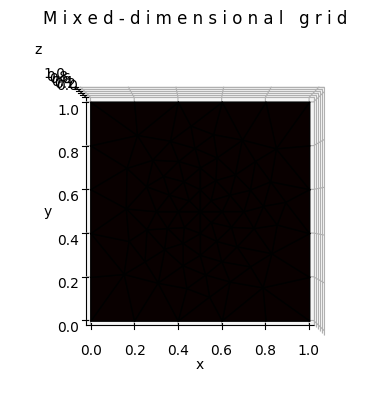

In [5]:
# Define the domain. The easiest option here is to set a box-shaped domain, specified by its min and max coordinates.
domain = pp.Domain({'xmin': 0, 'xmax': 1, 'ymin': 0, 'ymax': 1})

# A line fracture is defined by its endpoints, specified in the form of a numpy list.append
# The first row defines the x-coordinates, the second the y-coordinates, so this fracture
# runs from (0.3, 0.5) to (0.7, 0.5).
frac_1 = pp.LineFracture(np.array([[0.3, 0.7], [0.5, 0.5]]))

# We can define a second fracture. This will cross the first one in (0.5, 0.5)
frac_2 = pp.LineFracture(np.array([[0.5, 0.5], [0.3, 0.7]]))

# Add a third fracture which extends outside the domain
frac_3 = pp.LineFracture(np.array([[0.8, 1.2], [0.8, 1.2]]))

# Collect all fractures in a list
fracture_set = [frac_1, frac_2, frac_3]

# Define the fracture network.
network = pp.FractureNetwork2d(fracture_set, domain=domain)



## Mesh generation

In [ ]:

#pts = np.array([[0.3, 0.3], [0.3, 0.7]])
#edges = np.array([[0], [1]])
#network = pp.FractureNetwork2d(pts=pts, edges=edges, domain=domain)
mdg = network.mesh(mesh_args={'mesh_size_min': 0.03, 'mesh_size_bound': 0.2, 'mesh_size_frac':0.1})
pp.plot_grid(mdg)

In [6]:
mdg

Mixed-dimensional grid containing 4 grids and 4 interfaces.
Maximum dimension present: 2 
Minimum dimension present: 0 
1 grids of dimension 2 with in total 136 cells
2 grids of dimension 1 with in total 8 cells
1 grids of dimension 0 with in total 1 cells
2 interfaces between grids of dimension 2 and 1 with in total 16 mortar cells
2 interfaces between grids of dimension 1 and 0 with in total 4 mortar cells